# Stock Price Predictor

Dataset used- [NIFTY-50 Stock Market Data (2000 - 2021)](https://www.kaggle.com/datasets/rohanrao/nifty50-stock-market-data)

In [1]:
# Settings
SEQ_LEN = 365

#### Importing modules and Data Visualization

In [2]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from glob import glob
import pandas as pd
import numpy as np
from tqdm.notebook import trange
import matplotlib.pyplot as plt
%matplotlib inline

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DEVICE

device(type='cuda')

In [3]:
csv_list = glob("dataset\\stocks\\*.csv")

example = pd.read_csv(csv_list[0])
r = len(example)%(SEQ_LEN)
example = example.iloc[r:]
print(f"{len(example)}/{SEQ_LEN} = {len(example)//(SEQ_LEN)}")
example.head()

3285/365 = 9


,Date,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble
37,2008-01-21,MUNDRAPORT,EQ,994.60,995.0,1005.0,795.70,853.0,825.05,880.77,788623,6.945990e+13,NaN,474223,0.6013
38,2008-01-22,MUNDRAPORT,EQ,825.05,700.0,810.0,660.05,739.0,735.55,703.20,546161,3.840611e+13,NaN,376194,0.6888
39,2008-01-23,MUNDRAPORT,EQ,735.55,760.0,881.9,760.00,862.2,857.00,818.67,535462,4.383653e+13,NaN,283881,0.5302
40,2008-01-24,MUNDRAPORT,EQ,857.00,875.0,935.0,812.00,814.7,814.15,854.83,511017,4.368332e+13,NaN,258346,0.5056
41,2008-01-25,MUNDRAPORT,EQ,814.15,820.0,883.0,820.00,866.0,865.70,858.33,404045,3.468033e+13,NaN,178177,0.4410


Text(0.5, 0, 'Day')

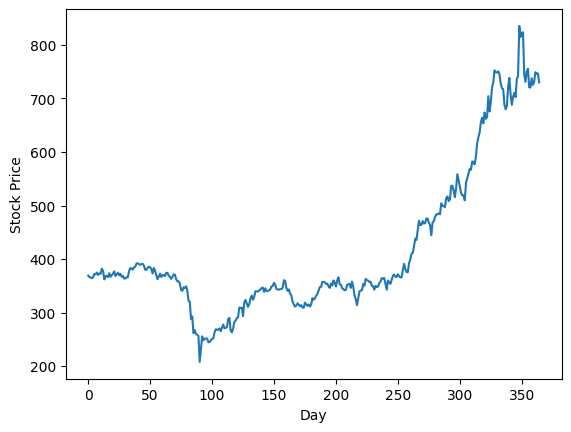

In [4]:
e = example[-(SEQ_LEN):].reset_index()
e[:SEQ_LEN]['Close'].plot()
plt.ylabel('Stock Price')
plt.xlabel('Day')

## Data fetching and preprocessing

In [5]:
def csv2array(csv_list: list[str], columns_to_keep: list[str], seq_len: int):
    
    def process_df(df):
        df = df[columns_to_keep]
        r = len(df) % seq_len
        n = len(df) // seq_len
        df = df.iloc[r:]
        arr_list = np.empty((0,seq_len,1), dtype=np.float32)
        for i in range(n):
            new_df = df.iloc[i*seq_len:(i+1)*seq_len]
            arr = new_df.to_numpy(dtype=np.float32)
            arr_list = np.append(arr_list, np.expand_dims(arr, 0), axis=0)
        
        return arr_list
    
    
    dataset = np.empty((0,seq_len,1), dtype=np.float32)
    for csv in csv_list:
            df = pd.read_csv(csv)
            arr_list = process_df(df)
            dataset = np.append(dataset, arr_list, axis=0)
            
    np.random.default_rng(1).shuffle(dataset)
    return dataset

dataset_orig = csv2array(csv_list, ['Close'], SEQ_LEN)
print(f'Dataset shape- {dataset_orig.shape}')
dataset_orig[0][0]

Dataset shape- (1263, 365, 1)


array([1159.], dtype=float32)

In [6]:
def scale_dataset(dataset):
    first = dataset[:,0:1,:]
    dataset = dataset/first
    return dataset

dataset = scale_dataset(dataset_orig)
dataset[0][0:3]

array([[1.       ],
       [1.0069025],
       [0.9981449]], dtype=float32)

In [7]:
class StockDataset(Dataset):
    def __init__(self, data_array):
        self.dataset = data_array
    
    def __len__(self):
        return self.dataset.shape[0]
    
    def __getitem__(self, i):
        arr = self.dataset[i]
        X = torch.from_numpy(arr[:-1])
        Y = torch.from_numpy(arr[1:])
        
        return {'X': X, 'Y': Y}
    
train_size = int(dataset.shape[0] * 0.90)

trainset = StockDataset(dataset[:train_size])
testset = StockDataset(dataset[train_size:])

print(f"Training Samples = {len(trainset)}\nTesting Samples = {len(testset)}")
print(f"Input sample shape = {trainset[0]['X'].shape}")
print(f"Output shape = {trainset[0]['Y'].shape}")

print(f"\nSamples:\nX- {trainset[0]['X'][0][0]}\nY- {trainset[0]['Y'][0][0]}")

Training Samples = 1136
Testing Samples = 127
Input sample shape = torch.Size([364, 1])
Output shape = torch.Size([364, 1])

Samples:
X- 1.0
Y- 1.0069024562835693


### Creating DataLoaders

In [8]:
train_dl = DataLoader(trainset, batch_size=32, shuffle=True, pin_memory=True)
test_dl = DataLoader(testset, batch_size=32, shuffle=True, pin_memory=True)

data = next(iter(train_dl))
print(f"X- {data['X'].shape}\nY- {data['Y'].shape}")

X- torch.Size([32, 364, 1])
Y- torch.Size([32, 364, 1])


## Model Building

#### Model

In [9]:
class StockPredictor(nn.Module):
    """
    Accepts input tensor of size (N, SEQ_LEN, 1).
    Returns output tensor of size (N, SEQ_LEN, 1).
    
    N - Batch Size
    SEQ_LEN - length of the sequence
    """
    def __init__(self, hidden_size: int, LSTM_layers: int, dropout: float= 0.,
                 learning_rate: float= 0.001):
        super().__init__()
        
        self.lstm = nn.LSTM(input_size=1, hidden_size=hidden_size, proj_size=0, num_layers=LSTM_layers, dropout=dropout, batch_first=True).to(DEVICE)
        
        layers = []
        if dropout > 0:
            layers += [nn.Dropout(dropout)]
        layers += [nn.Linear(hidden_size, 1)]
        self.top_layers = nn.Sequential(*layers).to(DEVICE)
        
        self.loss_func = nn.MSELoss()
        self.optimizer = torch.optim.Adam(self.parameters(), lr=learning_rate)
        
        self.eval()
    
    @staticmethod
    def normalize_data(data):
        first = data[...,0:1,:]
        data = data/first
        return data
    
    def forward(self, X, normalized=True, future = 1):
        X = X.to(DEVICE)
        if not normalized:
            X = self.normalize_data(X)

        lstm_out, states = self.lstm(X)
        output = self.top_layers(lstm_out)
        
        outputs = [output]
        output = output[..., -1:, :]
        for _ in range(future-1):
            lstm_out, states = self.lstm(output, states)
            output = self.top_layers(lstm_out)
            outputs.append(output)
        
        outputs = torch.cat(outputs, dim=-2)            
        return outputs
    
    def calculate_loss(self, X, Y, normalized=True):
        X, Y = X.to(DEVICE), Y.to(DEVICE)
        
        preds = self(X, normalized=normalized)
        loss = self.loss_func(preds, Y)
        return loss
    
    def optimize(self, X, Y):
        loss = self.calculate_loss(X, Y)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        return loss
    
model = StockPredictor(hidden_size=50, LSTM_layers=4, dropout= 0.2, learning_rate= 0.001)
print(f'Model Parameters- {sum(p.numel() for p in model.parameters())}')
model

Model Parameters- 71851


StockPredictor(
  (lstm): LSTM(1, 50, num_layers=4, batch_first=True, dropout=0.2)
  (top_layers): Sequential(
    (0): Dropout(p=0.2, inplace=False)
    (1): Linear(in_features=50, out_features=1, bias=True)
  )
  (loss_func): MSELoss()
)

### Model Training

#### Utility

In [10]:
class AverageCalculator:
    def __init__(self):
        self.reset()
        
    def update(self, num, count=1):
        self.count += count
        self.sum += num * count
        
    def average(self):
        return self.sum/self.count
        
    def reset(self):
        self.sum = self.count = 0.0

#### Training function

In [11]:
def train_model(model, train_dl: DataLoader, test_dl: DataLoader, epochs: int):
    train_losses = []
    test_losses = []
    
    print("\n\033[32mEpochs:\033[0m")
    for e in trange(epochs):
        calc = AverageCalculator()
        model.train()
        
        for data in train_dl:
            loss = model.optimize(data['X'], data['Y'])
            calc.update(float(loss.cpu().detach()), data['X'].shape[0])
        train_losses.append(calc.average())
        
        model.eval()
        calc.reset()
        
        with torch.no_grad():
            for data in test_dl:
                loss = model.calculate_loss(data['X'], data['Y'])
                calc.update(float(loss.cpu().detach()), data['X'].shape[0])
            test_losses.append(calc.average())
        
    print(f'Final Training Loss- {train_losses[-1]}')
    print(f'Final Testing Loss-  {test_losses[-1]}')

    return train_losses, test_losses

trainl, testl = train_model(model, train_dl, test_dl, 10)


Epochs:


  0%|          | 0/10 [00:00<?, ?it/s]

Final Training Loss- 0.06641236530013488
Final Testing Loss-  0.07281063105837685


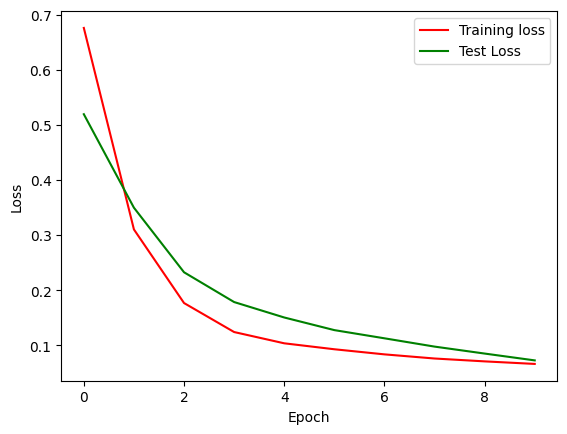

In [12]:
plt.plot(trainl, 'r', label= "Training loss")
plt.plot(testl, 'g', label= "Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(loc= 'best')

## Making Predictions with the trained model

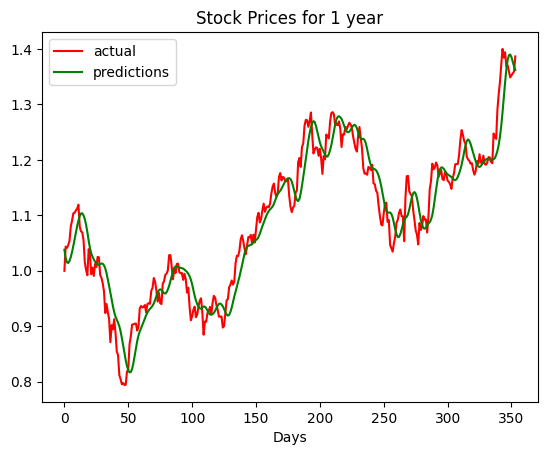

In [13]:
i = 3

data = testset[i]
with torch.no_grad():
    preds = model(data['X']).squeeze().cpu()

y = data['Y'].squeeze()

plt.plot(y[10:], 'r', label= "actual")
plt.plot(preds[10:], 'g', label= "predictions")
plt.xlabel("Days")
plt.title("Stock Prices for 1 year")
plt.legend(loc='best')